<center><img src="/images/nonlinearprogramming/thumbnail.jpg"></center>

In the age of digital marketing, businesses face the challenge of allocating their marketing budget across multiple channels to maximize sales.

However, as they broaden their reach, these firms inevitably face the issue of **diminishing returns** - the phenomenon where additional investment in a marketing channel yields progressively smaller increases in conversions. This is where the concept of marketing budget allocation steps in, adding another layer of complexity to the whole process.

In this article, we're going to explore the potential of nonlinear programming, specifically conic optimization (or cone programming), as a tool for marketing budget allocation. With the use of this advanced mathematical technique, we aim to optimize the distribution of marketing budget across various platforms to extract the maximum value and the highest possible ROI.

The code is available on [GitHub](https://github.com/mlabonne/linear-programming-course/blob/main/4_Maximize_Your_Marketing_ROI_with_Nonlinear_Optimization.ipynb) and [Google Colab](https://colab.research.google.com/drive/1V7z8giemuTk92s_JMxIyr1Clr2TwY7xl?usp=sharing).

## 💰 Marketing budget allocation

Marketing budget allocation is a critical aspect of any advertising campaign, requiring businesses to strategically distribute their resources across different channels. The goal is to maximize the effectiveness of their marketing efforts and achieve the highest possible return on investment (ROI). To tackle this challenge, we need to consider three key components:

1. **Attribution**: How can we connect conversion events to specific campaigns?
2. **Performance Estimation**: How can we predict the performance of a campaign based on its allocated budget?
3. **Optimization**: How can we allocate budgets across various campaigns to maximize ROI?

## 🔗 1. Attribution: Connecting Conversions to Campaigns

Attribution is the process of determining which campaigns are responsible for converting customers. Some channels, like Facebook or AdWords, can directly claim conversions. However, there are various attribution models to consider, including:

* First touch
* Last touch
* Multi-touch
* Time decay
* Position-based

Attribution systems are not without their issues, with two main challenges:

* **Lag**: The time it takes to measure the performance of ads and attribute conversions accurately
* **Attribution Window**: The trade-off between using a short versus a long window to attribute conversions

For example, DoorDash used a several-day last-touch attribution system. The problem they faced was the need to wait for several days to measure the performance of their ads, which proved too lengthy given the rapid changes in their market.

## 🔮 2. Performance Estimation: Predicting Campaign Success

Performance estimation involves creating a model that can predict the success of a marketing campaign based on its budget allocation. Here, success can be defined in terms of various Key Performance Indicators (KPIs), such as:

* Leads
* Cost per Lead (CPL)
* Customer Lifetime Value (CLV)
* Customer Acquisition Cost (CAC)

Traditionally, linear models have been used for performance estimation. However, they assume that marketing channels **don't exhibit diminishing returns**, which is often not the case. To obtain nontrivial solutions, linear models typically incorporate multiple constraints and are solved using Linear Programming (LP).

In reality, response curves in marketing mix modeling often display different shapes, such as:

* Linear (rare)
* Concave (common, indicating diminishing returns)
* Convex (rare)
* S-shaped (rare)

<center><img src="/images/nonlinearprogramming/response_curves.png" width=600></center>

These shapes reflect the **diminishing returns** of marketing spending or the varying effectiveness of different channels at different budget levels. For example, investing more money into a channel might initially yield higher returns (convex), but after a certain point, each additional dollar may generate less and less incremental outcome (becoming concave), creating an S-shaped curve overall.

To capture the intrinsic nonlinearity of the marketing budget allocation problem, a more sophisticated approach is needed. This is where nonlinear programming, specifically conic optimization, comes into play.

## 🔄 3. Optimization: Nonlinear Optimization with CVXPY

Nonlinear programming, also known as nonlinear optimization, is a method used to solve optimization problems where the **objective function**, **constraints**, or both, are **nonlinear**. In simple terms, it's the process of finding the optimal solution (either maximizing or minimizing) for a system that's governed by a set of nonlinear equations.

In this example, we will model the returns for each marketing channel (response curve) using the natural logarithm as follows:

$$\text{returns}_i(\text{budget}_i) = \alpha_i + \beta_i \ln(\text{budget}_i)$$

The two previous steps of attribution and performance estimation approximate the values of $\alpha_i$ and $\beta_i$ for every channel $i$. Let's take a simple example with three channels:

\begin{align}
\text{Google} &= -9453.72 + 8256.21\ \ln(\text{budget}_1) \\
\text{Facebook} &= -8312.84 + 7764.20\ \ln(\text{budget}_2) \\
\text{YouTube} &= -7371.33 + 7953.36\ \ln(\text{budget}_3) \\
\end{align}

The noise observed in these values is typical in marketing budget allocation problems. Note that the alpha values are **negative**; this can be interpreted as the initial cost of engaging with a new marketing channel.

We can plot the response curves of each marketing channel using matplotlib.

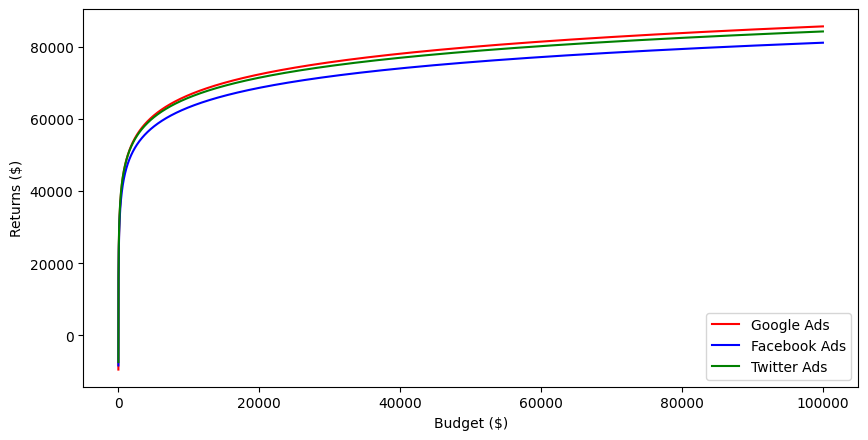

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

TOTAL_BUDGET = 100_000

# Alpha and beta constants
alphas = np.array([-9453.72, -8312.84, -7371.33])
betas = np.array([8256.21, 7764.20, 7953.36])

# Linearly spaced numbers
x = np.linspace(1, TOTAL_BUDGET, TOTAL_BUDGET)

# Plot the response curves
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.plot(x, alphas[0] + betas[0] * np.log(x), color='red', label='Google Ads')
plt.plot(x, alphas[1] + betas[1] * np.log(x), color='blue', label='Facebook Ads')
plt.plot(x, alphas[2] + betas[2] * np.log(x), color='green', label='Twitter Ads')
plt.xlabel('Budget ($)')
plt.ylabel('Returns ($)') 
plt.legend()
plt.show()

How to find the best values for each response curve? The easiest solution consists of a greedy algorithm that randomly samples values and evaluates the result. Our optimization problem can be described as follows:

\begin{align}
&\text{maximize}\quad \sum^N_{i=1} \alpha_i + \beta_i \ln(\text{budget}_i) \\
&\begin{aligned}\text{s.t.}\quad &\sum^N_{i=1} \text{budget}_i \leq \text{total budget}\\
&\text{budget}_i \geq 0\quad \forall i \in \mathbb{Z}, 1 \leq i \leq N
\end{aligned}
\end{align}

The following function has a budget of 1,000 iterations to find the best allocation.

In [2]:
def greedy_optimization(TOTAL_BUDGET, alphas, betas, num_iterations=1_000):
    # Initialize the budget allocation and the best objective value
    google_budget = facebook_budget = twitter_budget = TOTAL_BUDGET / 3
    obj = alphas[0] + betas[0] * np.log(google_budget) + alphas[1] + betas[1] * np.log(facebook_budget) + alphas[2] + betas[2] * np.log(twitter_budget)

    for _ in range(num_iterations):
        # Generate a new random allocation
        random_allocation = np.random.dirichlet(np.ones(3)) * TOTAL_BUDGET
        google_budget_new, facebook_budget_new, twitter_budget_new = random_allocation

        # Calculate the new objective value
        new_obj = alphas[0] + betas[0] * np.log(google_budget_new) + alphas[1] + betas[1] * np.log(facebook_budget_new) + alphas[2] + betas[2] * np.log(twitter_budget_new)

        # If the new allocation improves the objective value, keep it
        if new_obj > obj:
            google_budget, facebook_budget, twitter_budget = google_budget_new, facebook_budget_new, twitter_budget_new
            obj = new_obj

    # Return the best allocation and the corresponding objective value
    return (google_budget, facebook_budget, twitter_budget), obj

Let's run it and see the approximated solution it found:

In [3]:
%%time

# Run the greedy optimization
(best_google, best_facebook, best_twitter), obj = greedy_optimization(TOTAL_BUDGET, alphas, betas)

# Print the result
print('='*59 + '\n' + ' '*24 + 'Solution' + ' '*24 + '\n' + '='*59)
print(f'Returns = ${round(obj):,}\n')
print('Marketing allocation:')
print(f' - Google Ads   = ${round(best_google):,}')
print(f' - Facebook Ads = ${round(best_facebook):,}')
print(f' - Twitter Ads  = ${round(best_twitter):,}')

                        Solution                        
Returns = $224,534

Marketing allocation:
 - Google Ads   = $35,476
 - Facebook Ads = $31,722
 - Twitter Ads  = $32,802
CPU times: total: 0 ns
Wall time: 21.6 ms


After running our calculations, we find that our total return is $224,533. You might wonder if we can improve it by tweaking our model more or running more iterations.

This kind of guarantee is exactly where nonlinear programming comes to the rescue: it can output the **best solution possible**, also called the optimal solution. On top of this overwhelming advantage, it is also faster to run.

To solve the marketing budget allocation problem using nonlinear programming, we'll use the [**CVXPY**](https://www.cvxpy.org/) library, which supports conic optimization thanks to specialized solvers like [ECOS](https://github.com/embotech/ecos), [MOSEK](https://www.mosek.com/) (interior point method), and [SCS](https://github.com/cvxgrp/scs) (first-order method). In this example, we'll use the open-source ECOS solver to find the optimal solution.

Let's set up the optimization problem:

- Our decision **variables** are the (positive) budgets for each channel
- Our **constraint** is that the sum of all budgets must not exceed the total budget
- Our **objective** is to maximize the total return, which is the sum of the returns for each channel

In [4]:
import cvxpy as cp

# Variables
google   = cp.Variable(pos=True)
facebook = cp.Variable(pos=True)
twitter  = cp.Variable(pos=True)

# Constraint
constraint = [google + facebook + twitter <= TOTAL_BUDGET]

# Objective
obj = cp.Maximize(alphas[0] + betas[0] * cp.log(google)
                + alphas[1] + betas[1] * cp.log(facebook)
                + alphas[2] + betas[2] * cp.log(twitter))

Finally, we call the ECOS solver to find the optimal budget allocations and display the results.

In [5]:
%%time

# Solve
prob = cp.Problem(obj, constraint)
prob.solve(solver='ECOS', verbose=False)

# Print solution
print('='*59 + '\n' + ' '*24 + 'Solution' + ' '*24 + '\n' + '='*59)
print(f'Status = {prob.status}')
print(f'Returns = ${round(prob.value):,}\n')
print('Marketing allocation:')
print(f' - Google Ads   = ${round(google.value):,}')
print(f' - Facebook Ads = ${round(facebook.value):,}')
print(f' - Twitter Ads  = ${round(twitter.value):,}')

                        Solution                        
Status = optimal
Returns = $224,540

Marketing allocation:
 - Google Ads   = $34,439
 - Facebook Ads = $32,386
 - Twitter Ads  = $33,175
CPU times: total: 0 ns
Wall time: 13 ms


The optimal allocation found by the solver is \$34,439 for Google Ads, \$32,386 for Facebook Ads, and \$33,175 for YouTube, for a total return of \$224,540! This is **\$7 higher than what the greedy algorithm returned** ($224,533).

Keep in mind that this allocation maximizes the returns based on our response curves: correctly modeling these curves is crucial for optimizing the budget effectively.

Let's visualize this optimal allocation on top of the previous response curves.

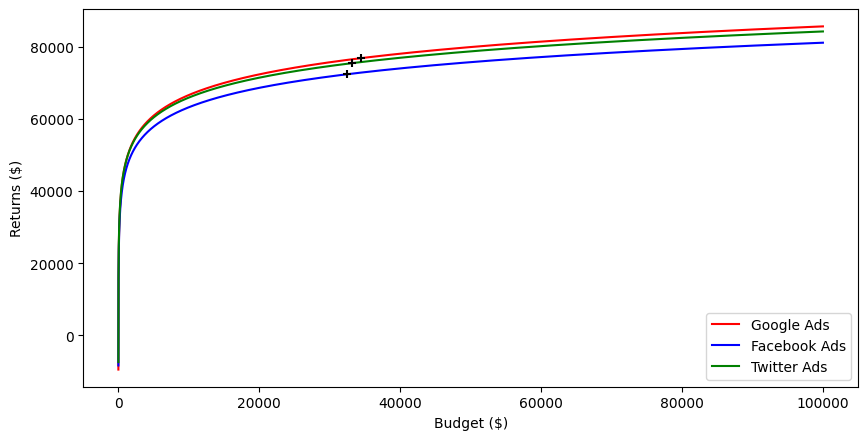

In [6]:
# Plot the functions and the results
fig = plt.figure(figsize=(10, 5), dpi=300)

plt.plot(x, alphas[0] + betas[0] * np.log(x), color='red', label='Google Ads')
plt.plot(x, alphas[1] + betas[1] * np.log(x), color='blue', label='Facebook Ads')
plt.plot(x, alphas[2] + betas[2] * np.log(x), color='green', label='Twitter Ads')

# Plot optimal points
plt.scatter([google.value, facebook.value, twitter.value],
            [alphas[0] + betas[0] * np.log(google.value),
             alphas[1] + betas[1] * np.log(facebook.value),
             alphas[2] + betas[2] * np.log(twitter.value)],
            marker="+", color='black', zorder=10)

plt.xlabel('Budget ($)')
plt.ylabel('Returns ($)') 
plt.legend()
plt.show()

But is it **really optimal**? We can do a quick sanity check by running the greedy algorithm for different numbers of iterations. This will show us the difference between these two approaches.

Let's run it for 20 different numbers of iterations between 1 and 1,000,000.

In [7]:
%%time

# List to store the best objective value for each number of iterations
best_obj_list = []

# Range of number of iterations to test
num_iterations_range = np.logspace(0, 6, 20).astype(int)

# Run the greedy algorithm for each number of iterations and store the best objective value
for num_iterations in num_iterations_range:
    _, best_obj = greedy_optimization(TOTAL_BUDGET, alphas, betas, num_iterations)
    best_obj_list.append(best_obj)

CPU times: total: 19.9 s
Wall time: 24.7 s


We can now plot the resulting list using matplotlib and compare it to the optimal solution:

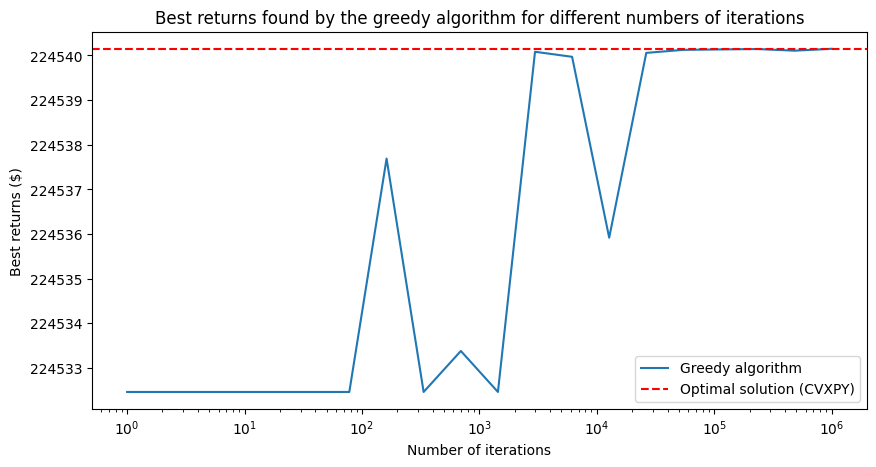

In [8]:
# Plot the results
plt.figure(figsize=(10, 5), dpi=300)
plt.ticklabel_format(useOffset=False)
plt.plot(num_iterations_range, best_obj_list, label='Greedy algorithm')
plt.axhline(y=prob.value, color='r', linestyle='--', label='Optimal solution (CVXPY)')
plt.xlabel('Number of iterations')
plt.xticks(num_iterations_range)
plt.xscale("log")
plt.ylabel('Best returns ($)')
plt.title('Best returns found by the greedy algorithm for different numbers of iterations')
plt.legend()
plt.show()

We observe that the greedy algorithm performs relatively well when given a large number of iterations. However, despite one million attempts, it falls just short of finding the optimal allocation, which yields a return of \$224,540.1500. The best non-rounded value it could reach is \$224,540.1489.

To add to this, there's a significant difference in terms of **computational speed** between the two approaches. The nonlinear programming model identified the optimal solution in a swift 22.3 milliseconds. In stark contrast, the greedy algorithm took a considerable 30 seconds to run its 1 million iterations and find a nearly optimal solution.

This disparity becomes even more crucial when we extend our problem to **numerous marketing channels**. Nonlinear programming with CVXPY maintains its speed and precision, making it a highly efficient tool for complex, high-dimensional marketing budget allocation problems.

## Conclusion

Nonlinear programming offers a powerful approach to tackling the marketing budget allocation problem. By modeling the diminishing returns of each marketing channel with **nonlinear functions** and leveraging the CVXPY library, we can find the optimal allocation of resources that maximizes sales.

As the marketing landscape evolves and the number of channels increases, optimization techniques like nonlinear programming can help businesses make better, data-driven decisions about their marketing investments. While this article provides a starting point, there are many more advanced techniques and models to explore. Keep learning and experimenting to find the best approach for your business.

If you’re interested to know more about it, feel free to follow me on Twitter [@maximelabonne](https://twitter.com/maximelabonne). Happy optimizing!

## References

If you want to learn more about marketing budget allocation, I recommend the following resources:

- [A Nonlinear Optimization Model of Advertising Budget Allocation across Multiple Digital Media Channels](https://scholarspace.manoa.hawaii.edu/server/api/core/bitstreams/ea6310e7-8ef8-4335-9625-b82b11042797/content) (Park et al., 2022): an excellent approach based on diminishing returns, which inspired this article.
- [A Unified Framework for Marketing Budget Allocation](https://arxiv.org/pdf/1902.01128.pdf) (Zhao et al., 2019): fascinating architecture currently in production at Alibaba, based on a logit response curve.
- [Cross-channel marketing spend optimization using deep learning](https://blog.griddynamics.com/cross-channel-marketing-spend-optimization-deep-learning/) (Katsov, 2019): blog post about an intriguing LSTM-based approach, without convex optimization.
- [Optimizing the marketing budget allocation problem using Lagrangean based techniques](https://thesis.eur.nl/pub/9800/9800-Giagkoulas.pdf): master thesis about a Lagrangean relaxation optimization approach.
- [Deriving a Marketing Budget Allocation Model Under Uncertain History Data](http://arno.uvt.nl/show.cgi?fid=146144): another master thesis focused on introducing uncertainty.

## 🥇 Linear Programming Course

<a href="https://github.com/mlabonne/Linear-Programming-Course" class="related">🔎 Course overview</a>

<a href="https://mlabonne.github.io/blog/linearoptimization/" class="related">📝 Chapter 1: Introduction to Linear Programming</a>

<a href="https://mlabonne.github.io/blog/integerprogramming/" class="related">📝 Chapter 2: Integer vs. Linear Programming</a>

<a href="https://mlabonne.github.io/blog/constraintprogramming/" class="related">📝 Chapter 3: Constraint Programming</a>

<a href="https://mlabonne.github.io/blog/nonlinearprogramming/" class="related">📝 Chapter 4: Nonlinear Programming for Marketing Budget Allocation</a>